Separate code to create +14 Europe BW Plots for comparing LSTM and RF models ...

Definition statements are copied from master PredPlot files, and axes are modified here for consistency. 
File generated 1/8/2026. 

In [9]:
#relevant import statements
import numpy as np
import math
import pandas as pd
import xarray as xr 
import pickle 
import matplotlib.pyplot as plt


#import seaborn as sns # statistical data visualization

##just to stop the excess number of warnings 
import warnings
warnings.filterwarnings('ignore')

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from geopy.distance import great_circle
import cartopy.crs as ccrs
from matplotlib.path import Path

In [10]:
#____________process input dataset____________

def preprocess_ellipse(input,shift,idx):
    print("Load data...")
    ##open ellipse metric files
    infile = open("../data/ellipse/wind10_redo.p", 'rb') 
    wind10 = pickle.load(infile)
    infile.close()

    infile = open("../data/ellipse/size10_redo.p", 'rb') 
    size10 = pickle.load(infile)
    infile.close()

    infile = open("../data/ellipse/ratio10_redo.p", 'rb') 
    rat10 = pickle.load(infile)
    infile.close()

    infile = open("../data/ellipse/ephi10_redo.p", 'rb') 
    ephi10 = pickle.load(infile)
    infile.close()

    infile = open("../data/ellipse/cenlat10_redo.p", 'rb')
    cenlat10 = pickle.load(infile)
    infile.close()

    infile = open("../data/ellipse/cenlon10_redo.p", 'rb')
    cenlon10 = pickle.load(infile)
    infile.close()

    infile = open("../data/gph/NA_gph_weightedANOM_100.p", 'rb') 
    gph = pickle.load(infile)
    infile.close()

    infile = open("../data/pv/CAP_pvu_weightedANOM_350.p", 'rb') 
    pv = pickle.load(infile)
    infile.close()
    print("Remove leap year and shift data...")
    #remove leap year
    wind10 = np.delete(wind10[:62],[151],1)
    rat10 = np.delete(rat10[:62],[151],1)
    cenlat10 = np.delete(cenlat10[:62],[151],1)
    cenlon10 = np.delete(cenlon10[:62],[151],1)
    size10 = np.delete(size10[:62],[151],1)
    ephi10 = np.delete(ephi10[:62],[151],1)

    #this is used to change the start date from October 19 to November 2nd... and just reduce the overall time observed. 
    
    wind10 = wind10[:,19+shift:168]
    rat10 = rat10[:,19+shift:168]
    cenlat10 = cenlat10[:,19+shift:168]
    cenlon10 = cenlon10[:,19+shift:168]
    size10 = size10[:,19+shift:168]
    ephi10 = ephi10[:,19+shift:168]
    gph = gph[:62,19+shift:168]
    pv = pv[:62,19+shift:168]
    
    print("Test wind shape:", wind10.shape)
    print(" ")
    print("Removing NaNs ...")
    #remove NaNs
    test_comp = []
    indices = np.isnan(wind10)
    for i in range(0,62):
        for j in range(0,idx):
            if indices[i,j] != False:
                #print(i)
                #print(j)
                #print("True")
                wind10[i,j] = 0
                rat10[i,j] = 0
                cenlat10[i,j] = 0
                cenlon10[i,j] = 0
                size10[i,j] = 0
                ephi10[i,j] = 0
                if i >= 57:
                    test_comp.append((i,j))
                else:
                    continue
    print("Returning final input array.")
    input[:,:,0] = wind10[:,:]
    input[:,:,1] = rat10[:,:]
    input[:,:,2] = cenlat10[:,:]
    input[:,:,3] = cenlon10[:,:]
    input[:,:,4] = size10[:,:]
    input[:,:,5] = ephi10[:,:]
    input[:,:,6] = gph[:,:]
    input[:,:,7] = pv[:,:]
    
    return input;

#____________calculate rates of events____________

#only for box and whisker plots
def BWcheckevent_label(posXtest,input2,idx):
    
    ##reduce input to just the testing data
    nolag_Xtest = input2[52:,:,:]
    nolag_Xtest.shape

    ####now I wanna make these plots SO ... I am adding an index column on to X_test ... full version. 
    ranges = np.array([x for x in range(0,idx*10,1)])
    ranges = ranges.reshape(10,idx) 
    ranges.shape
    
    ##Check whether event is in the desired list (true pos/neg or false pos/neg)
    posXtest_set = set(posXtest)

    pos_corr_events = []
    pos_corr_total_events = []
    
    for i in range(0,10):
        for j in range(0,idx):
            #index for the date being observed
            date_index = ranges[i,j]
            if date_index not in posXtest_set:
                continue
            elif date_index in posXtest_set:
                features = nolag_Xtest[i, j, :]
                pos_corr_events.extend(features)
                pos_corr_total_events.append(0)
                
    ##reshape
    Tpos = np.array(pos_corr_events).reshape(len(pos_corr_total_events),4)
    
    return Tpos;

In [11]:
#___________________________PLOTTING RELATED DEFINITIONS___________________________

def BWplot(Tpos,Tneg,Fpos,Fneg,metrics_list,loc_str,save_str):
    import matplotlib.ticker as mticker
    myLocator = mticker.MultipleLocator(2)

    metrics = metrics_list
    y1 = [-500,-10000000,-190,-40]
    y2 = [300,70000000,190,80]
    ticks = ['True +', 'False -', 'True -', 'False +'] #set tick numbers for dataset
    ind = [2, 4, 6, 8]  # the x locations for the groups
    w = 0.25 #box-plot width
    c = ["midnightblue","royalblue","mediumvioletred","magenta"]
    fs = 14

    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    plt.suptitle("Distribution of LSTM Input Features, "+str(loc_str), fontsize = 18, x=0.53)
    axes = axes.flatten()
    for i in range(0,4):
        C_pos = Tpos[:,i]
        F_neg = Fneg[:,i]
        C_neg = Tneg[:,i]
        F_pos = Fpos[:,i]
    
        a1 = axes[i].boxplot([C_pos, F_neg, C_neg, F_pos], positions=[2,4,6,8], widths=w, patch_artist=True)
    
        for patch, color in zip(a1['boxes'], c):
            patch.set_facecolor(color)
    
        axes[i].set_xticks(ind)
        axes[i].set_xticklabels(ticks)
        axes[i].set_ylabel(str(metrics[i]), fontsize=14)
        axes[i].set_ylim((y1[i],y2[i]))
        axes[i].tick_params(axis='both', labelsize=14)


    plt.tight_layout()
    plt.subplots_adjust(top=0.95)   
    plt.savefig(str(save_str),bbox_inches = 'tight')
    plt.show()
    return ;

In [12]:
##set up input file 
shift = 14
idx = 135 #129 for 20, 119 for 30.

input_metrics = np.empty((62,idx,8))
input = preprocess_ellipse(input_metrics,shift,idx)
input

Load data...
Remove leap year and shift data...
Test wind shape: (62, 135)
 
Removing NaNs ...
Returning final input array.


array([[[ 2.47599697e+01,  1.75386460e+00,  8.73529587e+01, ...,
          7.41090951e+01,  8.20421534e+01,  1.38378601e-01],
        [ 2.48346329e+01,  1.90333765e+00,  8.72026282e+01, ...,
          7.45326570e+01,  1.19906140e+02,  2.00446590e-01],
        [ 2.57907333e+01,  1.94319401e+00,  8.63205371e+01, ...,
          7.82445451e+01,  1.15771286e+02,  8.97867546e-02],
        ...,
        [ 3.64532700e+01,  1.16159156e+00,  8.47183391e+01, ...,
          1.01121249e+02, -1.76261679e+02, -9.05063548e-02],
        [ 3.44312019e+01,  1.11208075e+00,  8.42274559e+01, ...,
          8.22851492e+01, -1.60331940e+02, -2.14183384e-02],
        [ 3.29570198e+01,  1.24538832e+00,  8.47493430e+01, ...,
          8.39051194e+01, -1.35024313e+02, -4.18648642e-02]],

       [[ 1.80046349e+01,  1.32903736e+00,  7.63172533e+01, ...,
          1.24954313e+02,  1.36757884e+02,  4.12963333e-01],
        [ 1.80891266e+01,  1.39829317e+00,  7.56855007e+01, ...,
          1.24873833e+02,  1.52903531e

In [13]:
#separate input file py region based on feature selection
##Europe
eur_input = np.empty((62,idx,4))
eur_metrics_list = ["Geopotential Height (m)","Size (10$^7$m)",
                    "Central Longitude ($^o$)","Zonal-Mean Wind (m/s)"]
eur_input[:,:,0] = input[:,:,6]
eur_input[:,:,1] = input[:,:,4]
eur_input[:,:,2] = input[:,:,3]
eur_input[:,:,3] = input[:,:,0]

In [14]:
##Europe
infile = open("./index/posXtest_eur14.p", 'rb') 
eur_pos = pickle.load(infile)
infile.close()

infile = open("./index/FposXtest_eur14.p", 'rb') 
eur_Fpos = pickle.load(infile)
infile.close()

infile = open("./index/negXtest_eur14.p", 'rb') 
eur_neg = pickle.load(infile)
infile.close()

infile = open("./index/FnegXtest_eur14.p", 'rb') 
eur_Fneg = pickle.load(infile)
infile.close()

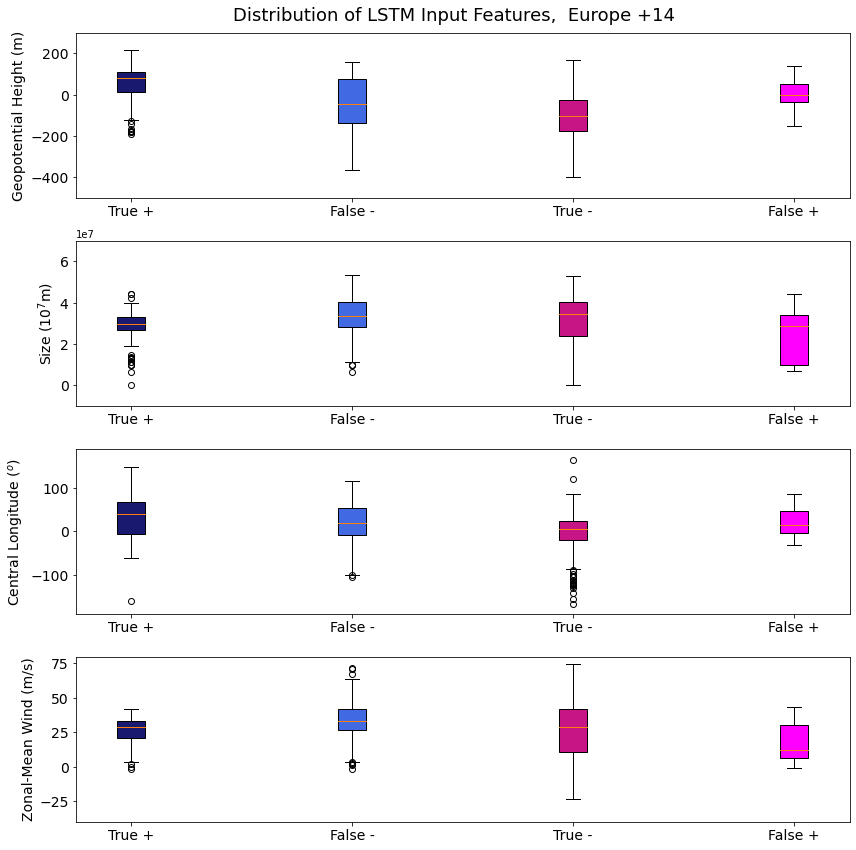

In [15]:
##Box and Whisker Plot Europe +14
Tpos = BWcheckevent_label(eur_pos,eur_input,idx)
Tneg = BWcheckevent_label(eur_neg,eur_input,idx)
Fpos = BWcheckevent_label(eur_Fpos,eur_input,idx)
Fneg = BWcheckevent_label(eur_Fneg,eur_input,idx)

BWplot(Tpos,Tneg,Fpos,Fneg,eur_metrics_list," Europe +14","testLSTM_eur14BW")

In [16]:
print(len(Tpos))
print(len(Fneg))
print(len(Tneg))
print(len(Fpos))

136
199
261
64
